# Introducing the Keras Sequential API

**Learning Objectives**
  - Build a DNN model using the Keras Sequential API
  - Learn how to use feature columns in a Keras model
  - Learn how to save/load, and deploy a Keras model on GCP

## Introduction

The [Keras sequential API](https://keras.io/models/sequential/) allows you to create Tensorflow models layer-by-layer. This is useful for building most kinds of machine learnig models but it does not allow you to create models that share layers, re-use layers or have multiple inputs or outputs. In this lab, we'll see how to build a simple deep neural network model using the keras sequential api and feature columns. Once we have trained our model, we will deploy it using AI Platform and see how to call our model for online prediciton.


In [1]:
#  Ensure that we have the latest version of Tensorflow installed.
!pip3 freeze | grep tf-nightly-2.0-preview || pip3 install tf-nightly-2.0-preview

tf-nightly-2.0-preview==2.0.0.dev20190731


Start by importing the necessary libraries for this lab.

In [2]:
import datetime
import os
import shutil

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

print(tf.__version__)

2.0.0-dev20190731


## Load raw data 

We will start with the CSV files that we wrote out in the [first notebook](../01_explore/taxifare.iypnb) of this sequence. Just so you don't have to run the notebook, we saved a copy in ../data.

In [3]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Sep  5 14:51 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Sep  5 14:51 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Sep  5 14:51 ../data/taxi-valid.csv


In [4]:
!head ../data/taxi*.csv

==> ../data/taxi-test.csv <==
6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8
7.0,2013-12-12 02:16:40 UTC,-73.985024,40.767537,-73.981273,40.779302,1,9

==> ../data/taxi-train.csv <==
11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866,1,0
7.7,2011-06-27 04:28:06 UTC,-73.987443,40.729221,-73.979013,40.758641,1,1
10.5,2011-04-03 0

## Use tf.data to read the CSV files

We wrote these functions for reading data in the [third notebook](../03_tfdata/input_pipeline.ipynb) of this sequence. We set up the column names from our csv files, denote the label column and specify the default values for each column.

In [5]:
CSV_COLUMNS = ['fare_amount',  'pickup_datetime',
               'pickup_longitude', 'pickup_latitude',
               'dropoff_longitude', 'dropoff_latitude',
               'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]


def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label


# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS).map(
            features_and_labels).cache()
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()
    dataset = dataset.prefetch(1)  # multi-threading; 1=AUTOTUNE
    return dataset

## Build a simple keras DNN model

We will use feature columns to connect our raw data to our keras DNN model. Feature columns make it easy to perform common type of feature engineering on your raw data. For example you can one-hot encode categorical data, create feature crosses, embeddings and more. We'll cover these later in the course, but if you want to a sneak peak browse the official TensorFlow [feature columns guide](https://www.tensorflow.org/guide/feature_columns).

In our case we won't do any feature engineering. However we still need to create a list of feature columns to specify the numeric values which will be passed on to our model. To do this we use `tf.feature_column.numeric_column()`

We use a python dictionary comprehension to create the feature columns for our model, which is just an elegant alternative to a for loop.

In [6]:
INPUT_COLS = ["pickup_longitude", "pickup_latitude",
              "dropoff_longitude", "dropoff_latitude",
              "passenger_count"]

# input layer of feature columns
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in INPUT_COLS
    }

Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

Before training a model, you must configure the learning process, which is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the [Optimizer class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers).
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the [Losses class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) (such as categorical_crossentropy or mse), or it can be a custom objective function.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.

We will add an additional custom metric called `rmse` to our list of metrics which will return the root mean square error. 

In [7]:
# Build a keras DNN model using Sequential API
model = keras.models.Sequential()
model.add(keras.layers.DenseFeatures(feature_columns=feature_columns.values()))
model.add(keras.layers.Dense(units=32, activation="relu", name="h1"))
model.add(keras.layers.Dense(units=8, activation="relu", name="h2"))
model.add(keras.layers.Dense(units=1, activation="linear", name="output"))


# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

## Train the model

To train our model, we typically use the `fit()` function. 

First, we'll set up some training variables like the batch size, the number of training examples, number of evaluations and number of evaluation examples. We'll choose a large number of training examples, since the training dataset repeats (similarly for the eval examples). Next, we create the training and evaluation dataset using the `load_dataset` function we wrote above. 

In [8]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = load_dataset(pattern='../data/taxi-train*',
                       batch_size=TRAIN_BATCH_SIZE,
                       mode=tf.estimator.ModeKeys.TRAIN)

evalds = load_dataset(
    pattern='../data/taxi-valid*',
    batch_size=1000,
    mode=tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

W0909 08:32:42.123051 139981592340224 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:521: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
W0909 08:32:42.163681 139981592340224 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:216: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizati

There are various arguments you can set when calling the [.fit() function](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)
. Here we will specify the training data, the evaluation data, the number of epochs for training and a parameter called `steps_per_epoch`. 

The `steps_per_epoch` parameter is used to mark the end of training for a single epoch. Since the data generator function continuously feeds training samples into the .fit() method, it is not possible to know the end of an epoch unless the parameter steps_per_epoch is specified. 

In [9]:
%%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(x=trainds,
                    validation_data=evalds,
                    epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/5


W0909 08:32:43.252182 139981592340224 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


312/312 [==============================] - 3s 8ms/step - loss: 92.6624 - rmse: 9.2118 - mse: 96.4339 - val_loss: 110.0854 - val_rmse: 10.4642 - val_mse: 110.0854
Epoch 2/5
312/312 [==============================] - 1s 4ms/step - loss: 95.4102 - rmse: 9.1724 - mse: 98.1792 - val_loss: 109.7061 - val_rmse: 10.4469 - val_mse: 109.7061
Epoch 3/5
312/312 [==============================] - 1s 4ms/step - loss: 97.8478 - rmse: 9.0902 - mse: 93.2564 - val_loss: 110.3649 - val_rmse: 10.4772 - val_mse: 110.3649
Epoch 4/5
312/312 [==============================] - 1s 4ms/step - loss: 93.6945 - rmse: 9.0391 - mse: 92.2763 - val_loss: 109.6348 - val_rmse: 10.4437 - val_mse: 109.6348
Epoch 5/5
312/312 [==============================] - 1s 4ms/step - loss: 95.4701 - rmse: 9.0978 - mse: 92.0002 - val_loss: 110.0495 - val_rmse: 10.4650 - val_mse: 110.0495
CPU times: user 10.9 s, sys: 1.53 s, total: 12.4 s
Wall time: 7.85 s


### High-level model evaluation

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can use the keras utilities to plot a diagram of our model architecture. And, we can plot the training and evaluation curves for the metrics we computed above. 

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
h1 (Dense)                   multiple                  192       
_________________________________________________________________
h2 (Dense)                   multiple                  264       
_________________________________________________________________
output (Dense)               multiple                  9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


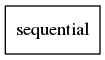

In [11]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=True, rankdir='LR')

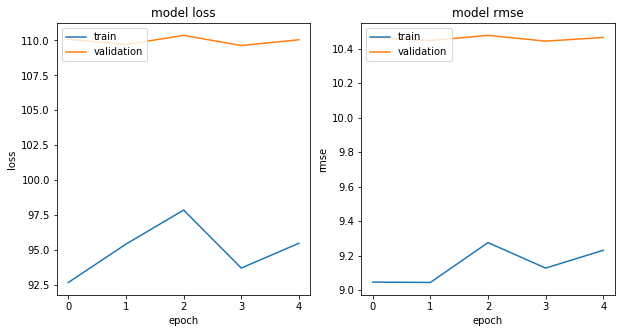

In [12]:
# plot train and validation curves
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "rmse"]):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history["val_{}".format(key)])
    plt.title("model {}".format(key))
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

# Making predictions with our model

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [13]:
model.predict(x={"pickup_longitude": tf.convert_to_tensor([-73.982683]),
                 "pickup_latitude": tf.convert_to_tensor([40.742104]),
                 "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
                 "dropoff_latitude": tf.convert_to_tensor([40.755174]),
                 "passenger_count": tf.convert_to_tensor([3.0])},
              steps=1)

array([[12.464289]], dtype=float32)

# Export and deploy our model

Of course, making individual predictions is not realistic, because we can't expect client code to have a model object in memory. For others to use our trained model, we'll have to export our model to a file, and expect client code to instantiate the model from that exported file. 

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [14]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR,
                           datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

W0909 08:32:51.501951 139981592340224 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1784: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_passenger_count:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
./export/savedmodel/20190909083250
./export/save

### Deploy our model to AI Platform

Finally, we will deploy our trained model to AI Platform and see how we can make online predicitons.

In [16]:
%%bash
PROJECT=munn-sandbox
BUCKET=${PROJECT}
REGION=us-east1
MODEL_NAME=taxifare
VERSION_NAME=dnn

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --python-version=3.5 --runtime-version=1.14 \
       --origin=$EXPORT_PATH --staging-bucket=gs://$BUCKET

taxifare already exists
Creating taxifare:dnn


In [17]:
%%writefile input.json
{"pickup_longitude": -73.982683, "pickup_latitude": 40.742104,"dropoff_longitude": -73.983766,"dropoff_latitude": 40.755174,"passenger_count": 3.0}  

Overwriting input.json


In [24]:
!gcloud ai-platform predict --model taxifare --json-instances input.json --version dnn

OUTPUT_1
[12.464288711547852]


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License